# Deacargar el Dataset 

In [2]:
!nvidia-smi

Mon Feb 14 12:32:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   23C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
#!pip install kaggle
#!chmod 600 kaggle.json
#!cp kaggle.json  ~/.kaggle/kaggle.json

In [15]:
#!kaggle competitions download -c dogs-vs-cats

100%|████████████████████████████████████████▊| 809M/812M [00:08<00:00, 129MB/s]
100%|████████████████████████████████████████| 812M/812M [00:13<00:00, 65.0MB/s]


In [23]:
#!unzip -q dogs-vs-cats.zip 
!unzip -q train.zip 

In [24]:
!unzip -q test1.zip

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os, shutil, pathlib
import matplotlib.pyplot as plt

from tensorflow.keras.utils import image_dataset_from_directory


print (tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.6.2
Num GPUs Available:  1


In [4]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:',tf.test.gpu_device_name())
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [7]:
original_dir = pathlib.Path("../train")
new_base_dir = pathlib.Path("../cats_vs_dogs_small")

In [8]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [14]:
!ls ../train | wc -l
!ls ../test1 | wc -l
!ls ../cats_vs_dogs_small/train/cat | wc -l
!ls ../cats_vs_dogs_small/train/dog | wc -l
!ls ../cats_vs_dogs_small/validation/cat | wc -l
!ls ../cats_vs_dogs_small/validation/dog | wc -l
!ls ../cats_vs_dogs_small/test/cat | wc -l
!ls ../cats_vs_dogs_small/test/dog | wc -l

25000
12500
1000
1000
500
500
1000
1000


# Dataloader y pre processing

In [19]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### Creando una capa de data augmentation

In [20]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

### Algunas imágenes de muestra

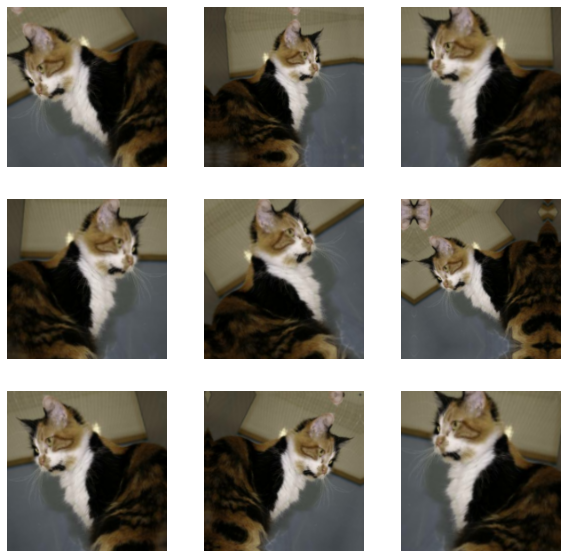

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Creando y compilando una ConvNet (con augmentation y Dropout)

In [22]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0     

# Ajustando el modelo 2.0

In [24]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-02-14 12:48:03.061 tensorflow-2-6-gpu--ml-g4dn-xlarge-0201d392adbb6351f674da89d00b:323 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-02-14 12:48:03.087 tensorflow-2-6-gpu--ml-g4dn-xlarge-0201d392adbb6351f674da89d00b:323 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
63/63 [==============================] - 13s 136ms/step - loss: 0.6980 - accuracy: 0.5290 - val_loss: 0.6858 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 4s 55ms/step - loss: 0.6919 - accuracy: 0.5325 - val_loss: 0.6899 - val_accuracy: 0.5020
Epoch 3/100
63/63 [===

# Loss y accuracy en training

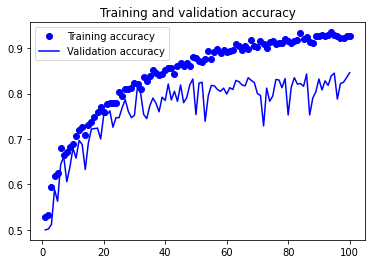

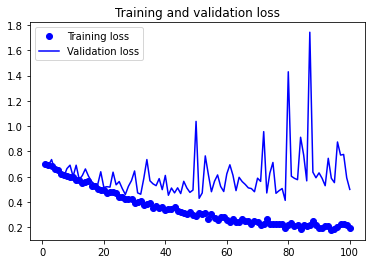

In [25]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Evauacion en el test

In [27]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 28ms/step - loss: 0.4672 - accuracy: 0.8225
Test accuracy: 0.822
